<a href="https://colab.research.google.com/github/d4rkl0rd3r3b05/AI_ML/blob/main/Food101_Classification_Custom_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing required packages

In [ ]:
## Install missing packages
!pip install -q torchmetrics

try:
  import torchinfo
except:
  !pip install -q torchinfo

from torchinfo import summary

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.5/869.5 kB 9.2 MB/s eta 0:00:00


In [ ]:
# Torch imports
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as sample_datasets
import torchvision

# Images modelling imports
from torchvision import datasets
import torchvision.transforms as T
from torchvision.transforms import ToTensor, Compose, Resize, RandomHorizontalFlip, TrivialAugmentWide


# Torchmetrics import
from torchmetrics import Accuracy, ConfusionMatrix

# Performance benchmark imports
from tqdm.auto import tqdm
from timeit import default_timer as timer

# Network resource imports
import requests
from pathlib import Path

# core packages
import os
import zipfile
import glob
import random
import math
from typing import Dict, List

# Data representation imports
import matplotlib.pyplot as plt
from PIL import Image
from mlxtend.plotting import plot_confusion_matrix

## Downloading Food101 limited data

In [ ]:
data_dir = Path("data/")
image_sample_dir = data_dir / "images/"

if image_sample_dir.is_dir():
  print("Sample Data already downloaded and available")
else:
  image_sample_dir.mkdir(parents=True, exist_ok=True)

  zip_data = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  with open(file=data_dir/"data.zip", mode="wb") as f:
    f.write(zip_data.content)

  with zipfile.ZipFile(data_dir/"data.zip","r") as zip_ref:
    zip_ref.extractall(image_sample_dir)

## Image Grid Plotter

In [ ]:
def plot_image_grid(X, y, pred=None, rows=4):
  """ Function to plot a grid of images with respective titles """

  fig = plt.figure(figsize=(15,10))

  number_of_images = len(y)
  columns = math.ceil(number_of_images/rows)

  for index in range(1, number_of_images+1):
    fig.add_subplot(rows, columns, index)

    img = X[index-1]
    transformer = T.ToPILImage()
    img_scaled = transformer(img).resize((160, 160))

    label = classes[y[index-1]]
    pred_label = "" if pred is None else classes[pred[index-1]]

    plt.imshow(img_scaled, cmap='gray')

    if pred is None:
      plt.title(label, fontsize=8, c='b', wrap=True)
    else:
      if pred_label ==  label :
        plt.title(f"True:{label}| Pred:{pred_label}", fontsize=8, c='g', wrap=True)
      else:
        plt.title(f"True:{label}| Pred:{pred_label}", fontsize=8, c='r', wrap=True)


    plt.axis(False)
    fig.subplots_adjust(top=1)
    fig.tight_layout()


## Inspecting the data

Root: data/images| Files: 0
Root: data/images/train| Files: 0
Root: data/images/train/pizza| Files: 78
Root: data/images/train/steak| Files: 75
Root: data/images/train/sushi| Files: 72
Root: data/images/test| Files: 0
Root: data/images/test/pizza| Files: 25
Root: data/images/test/steak| Files: 19
Root: data/images/test/sushi| Files: 31


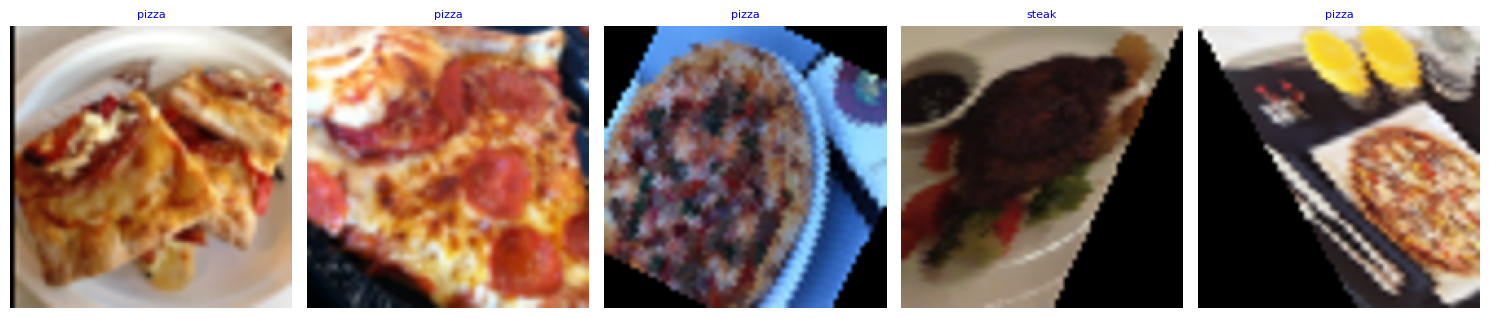

In [ ]:
for root, dirs, files in os.walk(image_sample_dir):
  print(f"Root: {root}| Files: {len(files)}")

# Getting all images
images = glob.glob("*/*/*.jpg", root_dir=image_sample_dir)

# Displaying random sample image
selected_image = random.choice(images)
Image.open(image_sample_dir/selected_image)

# Selecting random images
random_image_collection = random.sample(images, k = 8)

train_transformer = Compose([Resize(size=(64,64)),
                      TrivialAugmentWide(num_magnitude_bins=31),
                      ToTensor()])

test_transformer = Compose([Resize(size=(64,64)),
                      ToTensor()])

test_dataset = datasets.ImageFolder(root=image_sample_dir/"test", transform=test_transformer)
train_dataset = datasets.ImageFolder(root=image_sample_dir/"train", transform=train_transformer)

len(test_dataset), len(train_dataset)

train_dataloader = DataLoader(dataset=train_dataset, batch_size=5, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=5, shuffle=False)

classes = train_dataset.classes
classe_to_idx = train_dataset.class_to_idx
classes, classe_to_idx

X,y = next(iter(train_dataloader))
plot_image_grid(X=X, y=y, rows=1)

## Custom Dataset

torch.Size([64, 64, 3])

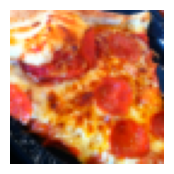

In [ ]:
class ImageFolderCustom(Dataset):
  def __init__(self, root: str, transformer = None):
    super().__init__()

    self.classes = sorted(entry.name for entry in os.scandir(root) if entry.is_dir())
    self.class_to_idx = {class_name:index for index, class_name in enumerate(self.classes)}
    self.img_paths = glob.glob("*/*.jpg", root_dir=root)
    self.transformer = transformer
    self.root_dir = root

  def __getitem__(self, index):
    selected_img_path = Path(self.img_paths[index])
    selected_img_class = selected_img_path.parent.stem

    img_index = self.class_to_idx[selected_img_class]

    img = Image.open(self.root_dir/selected_img_path)
    img = self.transformer(img) if self.transformer else img

    return img, img_index

  def __len__(self):
    return len(self.img_paths)


train_dataset_custom = ImageFolderCustom(root=image_sample_dir/"train", transformer=train_transformer)
test_dataset_custom = ImageFolderCustom(root=image_sample_dir/"test", transformer=test_transformer)

train_dataloader_custom = DataLoader(dataset=train_dataset_custom, batch_size=5, shuffle=True)
test_dataloader_custom = DataLoader(dataset=test_dataset_custom, batch_size=5, shuffle=False)


plt.figure(figsize=(2,2))
plt.imshow((train_dataset_custom[0][0]).permute(1,2,0))
plt.axis(False)
len(train_dataset_custom), train_dataset_custom.classes, train_dataset_custom.class_to_idx

(train_dataset_custom[0][0]).permute(1,2,0).shape

In [ ]:
# Define classification model
class ImageClassifier(nn.Module):
  def __init__(self, input_features, output_features, hidden_nodes=8):
    super().__init__()

    self.block_1 = nn.Sequential(nn.Conv2d(input_features, hidden_nodes, kernel_size=3,padding=0),
                                 nn.Conv2d(hidden_nodes, hidden_nodes, kernel_size=3,padding=0),
                                 nn.MaxPool2d(2,stride=2))

    self.block_2 = nn.Sequential(nn.Conv2d(hidden_nodes, hidden_nodes, kernel_size=4,padding=0),
                                 nn.Conv2d(hidden_nodes, hidden_nodes, kernel_size=4,padding=0),
                                 nn.MaxPool2d(4,stride=4))

    self.block_3 = nn.Sequential(nn.Conv2d(hidden_nodes, hidden_nodes, kernel_size=3,padding=0),
                                 nn.Conv2d(hidden_nodes, hidden_nodes, kernel_size=3,padding=0),
                                 nn.MaxPool2d(2,stride=2))

    self.classifier = nn.Sequential(nn.Flatten(),
                                    nn.Linear(in_features=hidden_nodes, out_features=output_features))


  def forward(self, x: torch.tensor) -> torch.tensor:
    x = self.block_1(x)
    x = self.block_2(x)
    x = self.block_3(x)
    return self.classifier(x)


classifier = ImageClassifier(input_features=3, output_features=len(train_dataset_custom.classes))

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(params=classifier.parameters(), lr=0.01)
accuracy_fn = Accuracy(task="multiclass", num_classes=len(train_dataset_custom.classes))

In [ ]:
# Training Loop
def train_step(model: nn.Module,
               criterion: nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               dataloader: torch.utils.data.DataLoader):

  total_loss, total_accuracy = 0, 0
  for batch, (X,y) in tqdm(enumerate(dataloader),total=len(dataloader)):
    model.train()

    pred = model(X)

    loss = criterion(pred, y)
    accuracy = accuracy_fn(pred, y)

    total_loss += loss
    total_accuracy += accuracy

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 200 == 0:
      print(f"Training for Batch: {batch} | Loss: {loss} | Accuracy: {accuracy*100:.2f}")

  avg_loss = total_loss/len(dataloader)
  avg_accuracy = total_accuracy/len(dataloader)
  print(f"Training complete with Average Total Loss: {avg_loss} & Average Total Accuracy: {avg_accuracy*100:.2f}" )

  return (avg_loss, avg_accuracy)

# Testing Loop
def test_step(model: nn.Module,
              criterion: nn.Module,
              accuracy_fn,
              dataloader: torch.utils.data.DataLoader):

  model.eval()
  with torch.inference_mode():
    total_loss, total_accuracy = 0, 0
    pred_labels = []
    for batch, (X,y) in tqdm(enumerate(dataloader),total=len(dataloader)):
      pred_logits = model(X)
      pred = pred_logits.argmax(dim=1)
      pred_labels.append(pred)


      loss = criterion(pred_logits, y)
      accuracy = accuracy_fn(pred_logits, y)

      total_loss += loss
      total_accuracy += accuracy

    avg_loss = total_loss/len(dataloader)
    avg_accuracy = total_accuracy/len(dataloader)
    print(f"Testing complete with Average Total Loss: {avg_loss} & Average Total Accuracy: {avg_accuracy*100:.2f}" )

    return (avg_loss, avg_accuracy, pred_labels)

In [ ]:
EPOCH = 10

start_time = timer()

total_train_loss, total_train_accuracy = 0, 0
total_test_loss, total_test_accuracy = 0, 0

#Create empty results dictionary
results = {"train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": []
}

for index in range(EPOCH):
  total_train_loss, total_train_accuracy = train_step(classifier,
                                                      criterion = criterion,
                                                      optimizer=optimizer,
                                                      accuracy_fn=accuracy_fn,
                                                      dataloader=train_dataloader_custom)

  total_test_loss, total_test_accuracy, pred_labels = test_step(classifier,
                                                                criterion = criterion,
                                                                accuracy_fn=accuracy_fn,
                                                                dataloader=test_dataloader_custom)

  results["train_loss"].append(total_train_loss.item() if isinstance(total_train_loss, torch.Tensor) else total_train_loss)
  results["train_acc"].append(total_train_accuracy.item() if isinstance(total_train_accuracy, torch.Tensor) else total_train_accuracy)
  results["test_loss"].append(total_test_loss.item() if isinstance(total_test_loss, torch.Tensor) else total_test_loss)
  results["test_acc"].append(total_test_accuracy.item() if isinstance(total_test_accuracy, torch.Tensor) else total_test_accuracy)


end_time = timer()

print(f"Modelling complete in {end_time-start_time}")
print(f"Train Results: Train Total Loss: {total_train_loss} & Train Total Accuracy: {total_train_accuracy*100:.2f}" )
print(f"Train Results: Test Total Loss: {total_test_loss} & Test Total Accuracy: {total_test_accuracy*100:.2f}" )


  0%|          | 0/45 [00:00<?, ?it/s]

Training for Batch: 0 | Loss: 1.1427425146102905 | Accuracy: 0.00
Training complete with Average Total Loss: 1.0984716415405273 & Average Total Accuracy: 34.67


  0%|          | 0/15 [00:00<?, ?it/s]

Testing complete with Average Total Loss: 1.0948374271392822 & Average Total Accuracy: 33.33


  0%|          | 0/45 [00:00<?, ?it/s]

Training for Batch: 0 | Loss: 1.1375550031661987 | Accuracy: 0.00
Training complete with Average Total Loss: 1.0974980592727661 & Average Total Accuracy: 34.67


  0%|          | 0/15 [00:00<?, ?it/s]

Testing complete with Average Total Loss: 1.0948808193206787 & Average Total Accuracy: 33.33


  0%|          | 0/45 [00:00<?, ?it/s]

Training for Batch: 0 | Loss: 1.114714503288269 | Accuracy: 20.00
Training complete with Average Total Loss: 1.096073031425476 & Average Total Accuracy: 34.22


  0%|          | 0/15 [00:00<?, ?it/s]

Testing complete with Average Total Loss: 1.0931791067123413 & Average Total Accuracy: 33.33


  0%|          | 0/45 [00:00<?, ?it/s]

Training for Batch: 0 | Loss: 1.0871315002441406 | Accuracy: 40.00
Training complete with Average Total Loss: 1.0925092697143555 & Average Total Accuracy: 35.11


  0%|          | 0/15 [00:00<?, ?it/s]

Testing complete with Average Total Loss: 1.090814232826233 & Average Total Accuracy: 33.33


  0%|          | 0/45 [00:00<?, ?it/s]

Training for Batch: 0 | Loss: 1.1263920068740845 | Accuracy: 0.00
Training complete with Average Total Loss: 1.0870518684387207 & Average Total Accuracy: 35.11


  0%|          | 0/15 [00:00<?, ?it/s]

Testing complete with Average Total Loss: 1.0842045545578003 & Average Total Accuracy: 33.33


  0%|          | 0/45 [00:00<?, ?it/s]

Training for Batch: 0 | Loss: 1.1126317977905273 | Accuracy: 20.00
Training complete with Average Total Loss: 1.0866987705230713 & Average Total Accuracy: 36.89


  0%|          | 0/15 [00:00<?, ?it/s]

Testing complete with Average Total Loss: 1.0781810283660889 & Average Total Accuracy: 37.33


  0%|          | 0/45 [00:00<?, ?it/s]

Training for Batch: 0 | Loss: 1.1169896125793457 | Accuracy: 20.00
Training complete with Average Total Loss: 1.072786569595337 & Average Total Accuracy: 46.22


  0%|          | 0/15 [00:00<?, ?it/s]

Testing complete with Average Total Loss: 1.0684536695480347 & Average Total Accuracy: 33.33


  0%|          | 0/45 [00:00<?, ?it/s]

Training for Batch: 0 | Loss: 1.1988085508346558 | Accuracy: 0.00
Training complete with Average Total Loss: 1.0549644231796265 & Average Total Accuracy: 41.33


  0%|          | 0/15 [00:00<?, ?it/s]

Testing complete with Average Total Loss: 1.055341362953186 & Average Total Accuracy: 38.67


  0%|          | 0/45 [00:00<?, ?it/s]

Training for Batch: 0 | Loss: 1.0499651432037354 | Accuracy: 40.00
Training complete with Average Total Loss: 1.03683602809906 & Average Total Accuracy: 49.33


  0%|          | 0/15 [00:00<?, ?it/s]

Testing complete with Average Total Loss: 1.0332014560699463 & Average Total Accuracy: 40.00


  0%|          | 0/45 [00:00<?, ?it/s]

Training for Batch: 0 | Loss: 1.2381547689437866 | Accuracy: 0.00
Training complete with Average Total Loss: 1.0173035860061646 & Average Total Accuracy: 46.22


  0%|          | 0/15 [00:00<?, ?it/s]

Testing complete with Average Total Loss: 1.0117733478546143 & Average Total Accuracy: 40.00
Modelling complete in 40.73816666299999
Train Results: Train Total Loss: 1.0173035860061646 & Train Total Accuracy: 46.22
Train Results: Test Total Loss: 1.0117733478546143 & Test Total Accuracy: 40.00


In [ ]:
summary(classifier, input_size=[5, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
ImageClassifier                          [5, 3]                    --
├─Sequential: 1-1                        [5, 8, 30, 30]            --
│    └─Conv2d: 2-1                       [5, 8, 62, 62]            224
│    └─Conv2d: 2-2                       [5, 8, 60, 60]            584
│    └─MaxPool2d: 2-3                    [5, 8, 30, 30]            --
├─Sequential: 1-2                        [5, 8, 6, 6]              --
│    └─Conv2d: 2-4                       [5, 8, 27, 27]            1,032
│    └─Conv2d: 2-5                       [5, 8, 24, 24]            1,032
│    └─MaxPool2d: 2-6                    [5, 8, 6, 6]              --
├─Sequential: 1-3                        [5, 8, 1, 1]              --
│    └─Conv2d: 2-7                       [5, 8, 4, 4]              584
│    └─Conv2d: 2-8                       [5, 8, 2, 2]              584
│    └─MaxPool2d: 2-9                    [5, 8, 1, 1]              --
├─Seq

In [ ]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

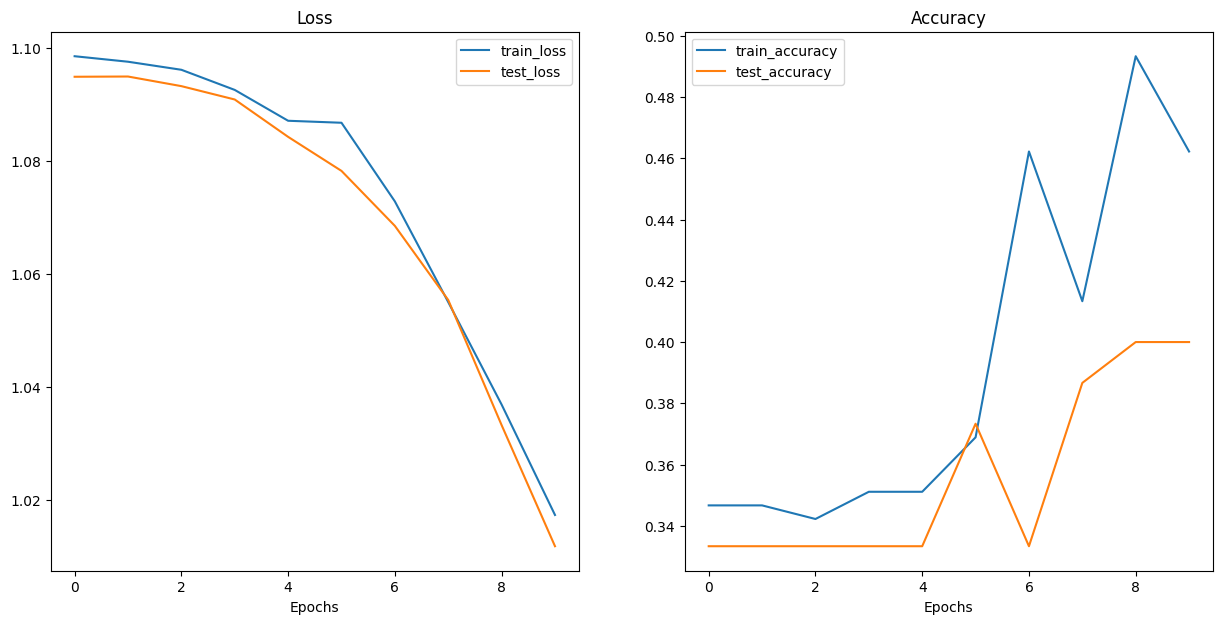

In [ ]:
plot_loss_curves(results=results)

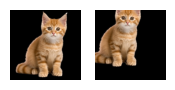

In [ ]:
import torchvision.transforms as transforms

plt.figure(figsize=(2,2))

original_image = transforms.ToTensor()(Image.open("cat.jpg"))
original_image.shape

# Sample application
def display_image(img, trsnfd_img):
  plt.subplot(121)
  plt.imshow(img.permute(1,2,0))
  plt.axis(False)

  plt.subplot(122)
  transformed_image = transforms.RandomHorizontalFlip(p=0.5)(original_image)
  plt.imshow(trsnfd_img.permute(1,2,0))
  plt.axis(False)


# random_horizontal_flipped_image = transforms.RandomHorizontalFlip(p=0.5)(original_image)
# display_image(original_image, random_horizontal_flipped_image)

# random_rotated_image = transforms.RandomRotation(degrees=45)(original_image)
# display_image(original_image, random_rotated_image)


# random_resized_cropped_image = transforms.RandomResizedCrop(size=(224, 224))(original_image)
# display_image(original_image, random_resized_cropped_image)


# random_color_jittered_image = transforms.ColorJitter(brightness=0.2,
#                                                      contrast=0.2, saturation=0.2,
#                                                      hue=0.1)(original_image)
# display_image(original_image, random_color_jittered_image)


random_normalized_image = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                               std=[0.229, 0.224, 0.225])(original_image)
display_image(original_image, random_normalized_image)



transformed_image = transforms.RandomAffine(degrees=0,
                                            translate=(0.2, 0.3))(original_image)
display_image(original_image, transformed_image)
